## Imports

In [1]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow import data
from tensorflow.keras import layers, Input, Model, losses, optimizers

## Data load

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


## Preprocessing

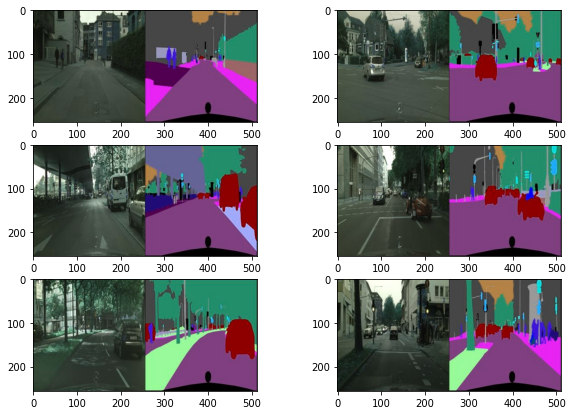

In [3]:
plt.figure(figsize=(10,7))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


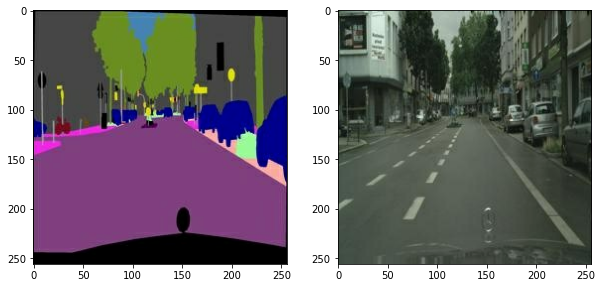

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Augmentation

#### Tensorflow augmentation

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

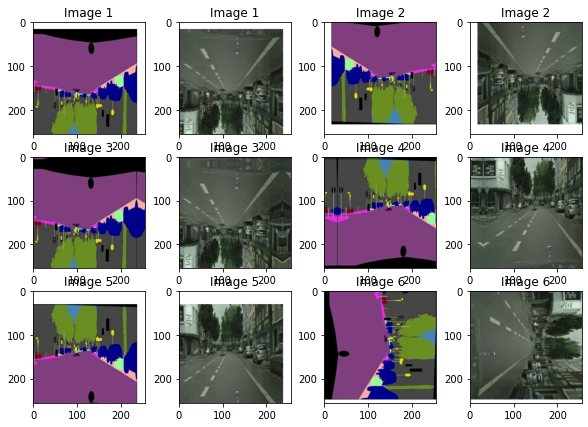

In [7]:
plt.figure(figsize=(10,7))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

#### Cutmix

In [8]:
@tf.function() 
def cutmix(segment, city, batch_size=2, img_size=256):
    ''' 입력: segment, city 이미지 리스트,
        파라미터: batch_size, img_size,
        서로 다른 두개의 이미지 리스트를 받아서 cutmix해준다.'''
    mixed_citys = []
    mixed_aurgs = []
    image = tf.concat([segment, city], axis=-1)
    
    for i in range(batch_size):
        image_a = image[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        
        mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
        mixed_citys.append(mixed_img[...,:3])
        mixed_aurgs.append(mixed_img[...,3:])
        
    mixed_city = tf.reshape(tf.stack(mixed_citys),(batch_size, img_size, img_size, 3))
    mixed_aurg = tf.reshape(tf.stack(mixed_aurgs),(batch_size, img_size, img_size, 3))                      
    return mixed_city, mixed_aurg

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=256):
    '''서로 다른 두 이미지 a, b가 있다면 a의 이미지에 crop된 b이미지를 붙여준다.'''
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def get_clip_box(image_a, image_b, img_size=256):
    '''랜덤으로 박스의 위치 좌표를 출력한다.'''
    x = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    y = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    
     # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

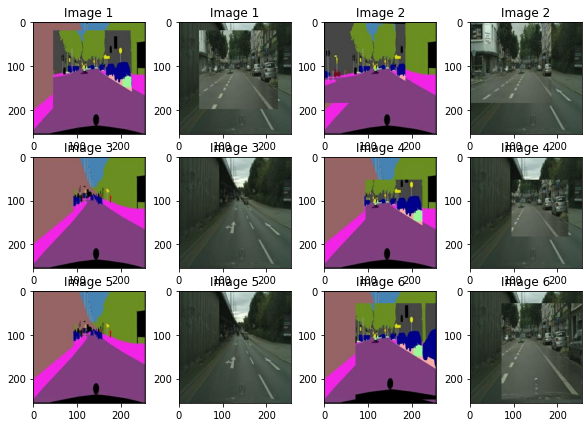

In [9]:
f = data_path + os.listdir(data_path)[1]
s = data_path + os.listdir(data_path)[2]
segment1, city1 = load_img(f)
segment2, city2 = load_img(s)
segment = [segment1, segment2]
city = [city1, city2]

# augmentation 적용 이미지 시각화
plt.figure(figsize=(10,7))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = cutmix(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment[1])); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city[1])); plt.title(f"Image {img_n}")
    img_n += 1

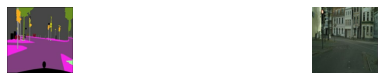

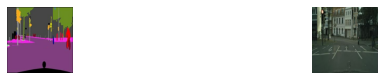

In [30]:
# 학습 데이터에 적용 시켜보기
from tensorflow import data

def get_train(ds, with_aug=False, with_cutmix=False):
    ds = ds.map(
            load_img 
        )
    if with_aug:
        ds = ds.map(
            apply_augmentation
        )
    if with_cutmix:
        ds = ds.batch(2)
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

image_path = data.Dataset.list_files(data_path + "*.jpg")
#train_images = get_train(image_path, with_aug=True).shuffle(100).batch(10)
train_images = get_train(image_path, with_cutmix=True).shuffle(100)
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, city = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

for i in range(2):
    plt.figure(figsize=(10,7))
    plt.subplot(5,2,i*2+1); plt.imshow(segment[i].astype(np.uint8));plt.axis('off')
    plt.subplot(5,2,(i+1)*2); plt.imshow(city[i].astype(np.uint8));plt.axis('off')

## Pix2Pix

In [11]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [12]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [14]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [16]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## U-Net

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

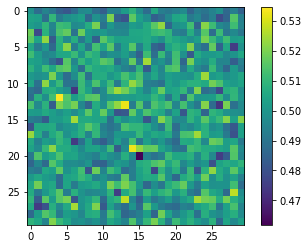

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [23]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [24]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [26]:
EPOCHS = 500

aug_history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

total_start = time.time()
for epoch in tqdm(range(1, EPOCHS+1)):
    epoch_start = time.time()
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)
    
    aug_history['g_loss'].append(g_loss.numpy())
    aug_history['l1_loss'].append(l1_loss.numpy())
    aug_history['d_loss'].append(d_loss.numpy())
    
    if (epoch+1) % 50 == 0:
        print(f"EPOCH[{epoch}] Generator_loss : {g_loss.numpy():.4f} L1_loss : {l1_loss.numpy():.4f} Discriminator_loss : {d_loss.numpy():.4f}  per epoch : {time.time() - epoch_start:0.2f}sec", end="\n\n")
        
print(f'총 소요시간 :, {time.time() - total_start}')  # 현재시각 - 시작시간 = 실행 시간

 10%|▉         | 49/500 [30:46<4:42:45, 37.62s/it]

EPOCH[49] Generator_loss : 1.9651 L1_loss : 0.1637 Discriminator_loss : 1.2359  per epoch : 37.59sec



 20%|█▉        | 99/500 [1:02:05<4:11:32, 37.64s/it]

EPOCH[99] Generator_loss : 2.2597 L1_loss : 0.1736 Discriminator_loss : 2.0493  per epoch : 37.69sec



 30%|██▉       | 149/500 [1:33:24<3:39:55, 37.59s/it]

EPOCH[149] Generator_loss : 0.9548 L1_loss : 0.1759 Discriminator_loss : 0.7056  per epoch : 37.67sec



 40%|███▉      | 199/500 [2:04:44<3:08:36, 37.60s/it]

EPOCH[199] Generator_loss : 1.2228 L1_loss : 0.1655 Discriminator_loss : 0.9584  per epoch : 37.60sec



 50%|████▉     | 249/500 [2:36:04<2:37:15, 37.59s/it]

EPOCH[249] Generator_loss : 1.7844 L1_loss : 0.1672 Discriminator_loss : 0.8751  per epoch : 37.57sec



 60%|█████▉    | 299/500 [3:07:23<2:06:01, 37.62s/it]

EPOCH[299] Generator_loss : 1.1311 L1_loss : 0.1672 Discriminator_loss : 0.7883  per epoch : 37.64sec



 70%|██████▉   | 349/500 [3:38:42<1:34:26, 37.53s/it]

EPOCH[349] Generator_loss : 2.3804 L1_loss : 0.1421 Discriminator_loss : 1.3493  per epoch : 37.54sec



 80%|███████▉  | 399/500 [4:10:04<1:03:15, 37.58s/it]

EPOCH[399] Generator_loss : 1.8928 L1_loss : 0.1628 Discriminator_loss : 0.3206  per epoch : 37.57sec



 90%|████████▉ | 449/500 [4:41:22<31:54, 37.54s/it]  

EPOCH[449] Generator_loss : 0.7347 L1_loss : 0.1524 Discriminator_loss : 0.9860  per epoch : 37.55sec



100%|█████████▉| 499/500 [5:12:42<00:37, 37.60s/it]

EPOCH[499] Generator_loss : 0.8390 L1_loss : 0.1484 Discriminator_loss : 1.2390  per epoch : 37.58sec



100%|██████████| 500/500 [5:13:19<00:00, 37.60s/it]

총 소요시간 :, 18799.930592536926


(-0.5, 255.5, 255.5, -0.5)

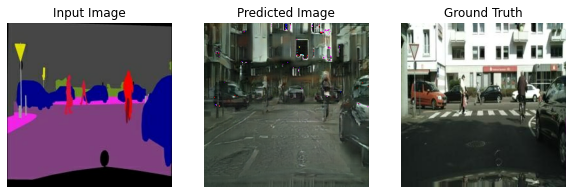

In [27]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(10,7))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

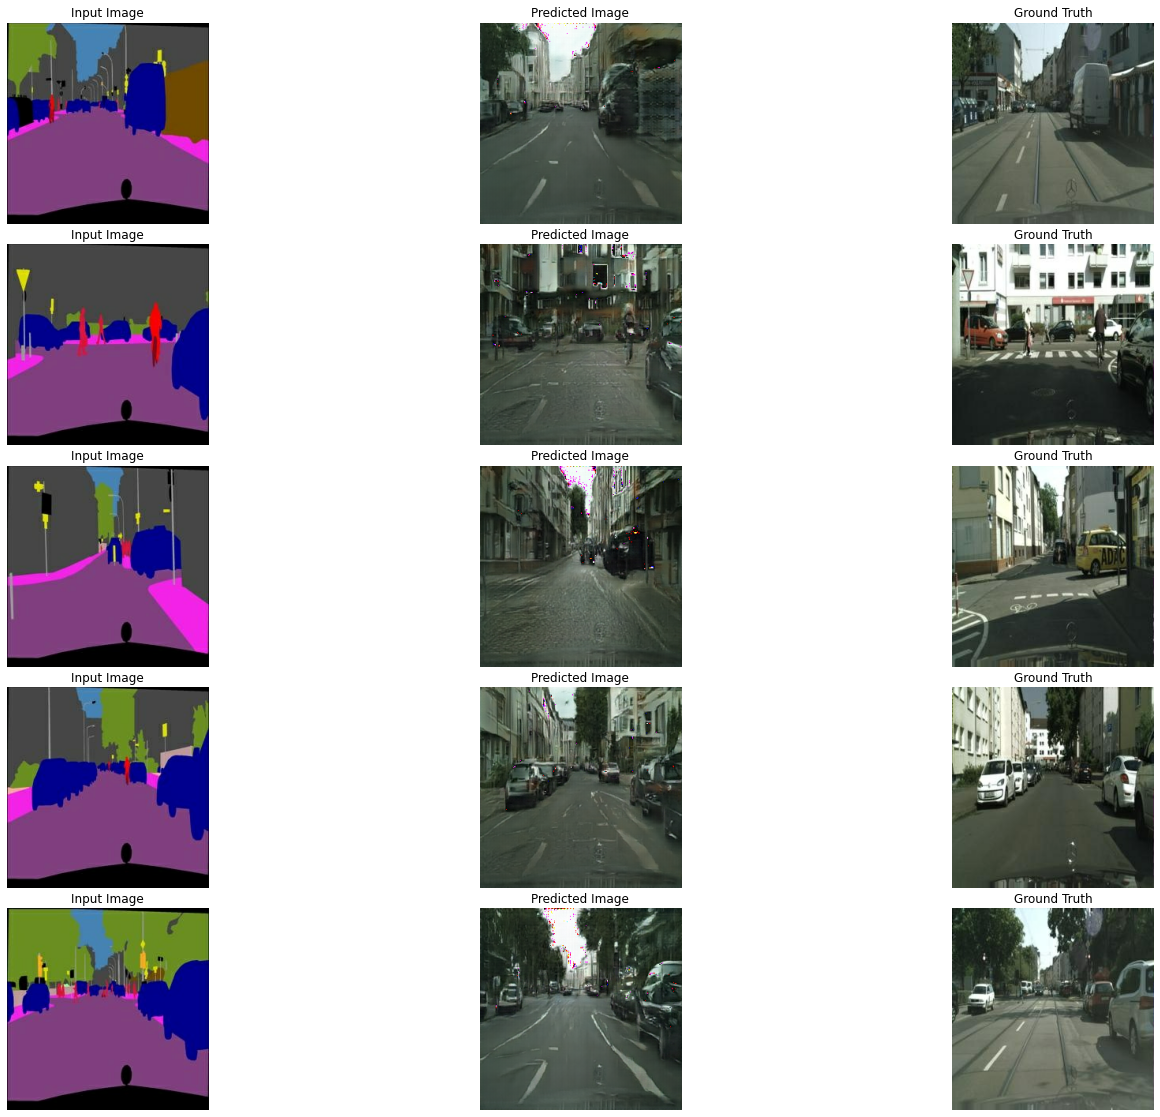

In [28]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
val_path = [test_path + path for path in os.listdir(test_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(25, 20))
plt.subplots_adjust(wspace=0.05, hspace=0.1)               
for i in range(5):
    plt.subplot(5,3, i + ((2*i)+1)); plt.imshow(seg_images[i]); plt.title('Input Image'); plt.axis('off')
    plt.subplot(5,3, i + ((2*i)+2)); plt.imshow(predict[i]); plt.title('Predicted Image'); plt.axis('off')
    plt.subplot(5,3, i + ((2*i)+3)); plt.imshow(real_images[i]);  plt.title('Ground Truth'); plt.axis('off')

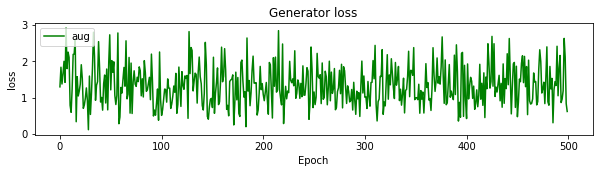

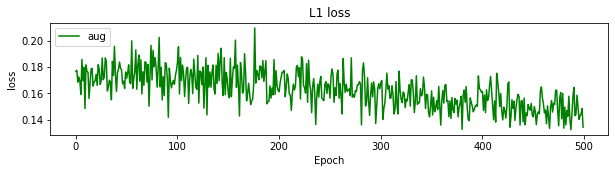

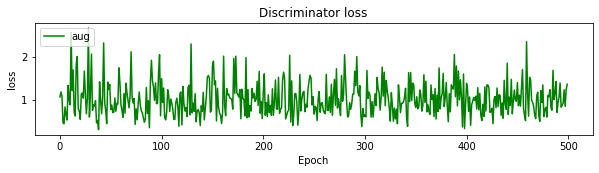

In [29]:
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.plot(aug_history['g_loss'], 'g')
plt.title('Generator loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 2)
plt.plot(aug_history['l1_loss'], 'g')
plt.title('L1 loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 3)
plt.plot(aug_history['d_loss'], 'g')
plt.title('Discriminator loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

## Discussion

1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.  
 - **데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.**
 - **노드에서 제공한 tensorflow의 augmentation방법과 더불어 네이버 클로바에서 만든 cutmix라는 augmentation 방법을 사용하였다.**  
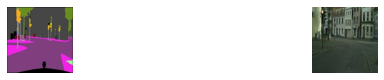
 - **Augmentation할때 결과가 위그림의 오른쪽에서와 같이 완전히 변형되어버려서, predicted image가 ground thuth와 완전히 다르게 예측되기 때문에, 학습과정에서는 tensorflow의 augmentation과정을 거친 이미지를 입력 이미지로 사용하였다.**  


2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.  
 - **U-Net generator, discriminator 모델 구현이 완료되어 500 epoch 동안 train_step이 안정적으로 진행됨을 확인하였다.**  


3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.  
 - **500 epoch로 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.**
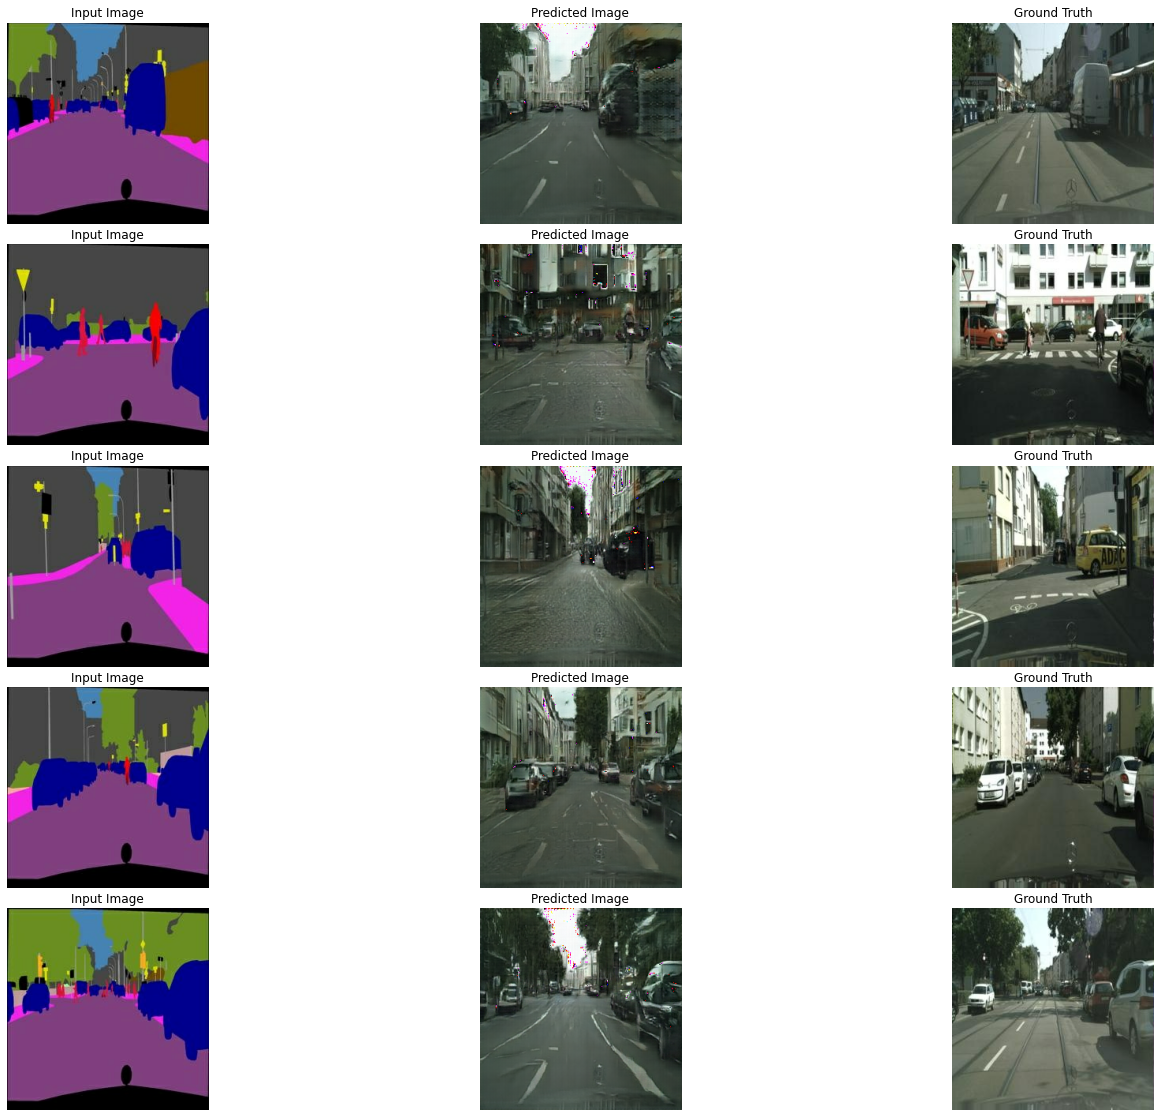

## Reference

1. https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E24_Conditional-Generative-Model.ipynb
2. https://github.com/SunCreation/aiffel/blob/main/Working/AI/AI_painter/%5BEX-19%5D.ipynb
3. https://github.com/seonghyun97/Aiffel_Exploration/blob/master/%5BE-16%5DColorbook.ipynb